# Chinese OCR

Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import time
import multiprocessing
from PIL import Image, ImageFont
from skimage.transform import resize

preprocessing

In [2]:
def preprocess_image(image_path):
    # Read image
    image = cv2.imread(image_path, 0)

    # Apply binary thresholding
    _, image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Perform dilation and erosion to remove some noise
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return image

extracting characters

In [6]:
def extract_characters(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # cv2.RETR_EXTERNAL
    
    output = image.copy()
    output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

    # clear output folder
    for images in os.scandir('chars/'):
        os.remove(images.path)

    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)

        if w > 20 and h > 20:
            idx = idx + 1

            # Draw the rectangle and segmentation
            cv2.rectangle(output, (x - 5, y - 5), (x + w + 5, y + h + 5), (0, 255, 255), 1)
            cv2.imwrite(f'chars/char_{idx}.png', image[y-1:y+h+1, x-1:x+w+1])

    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.show()

character recognition:

In [4]:
def getCharacterImage(character):
  img = Image.Image()._new(font.getmask(character))
  img = np.asarray(img)
  return (img / 255).astype(np.uint8)

def loadFont(font_size):
  global font
  # font_name = "resources/SourceHanSerif-VF.ttf.ttc"
  # font_name = "resources/Source Han Serif CN Heavy.otf"
  font_name = "resources/SourceHanSerifSC-Bold.otf"
  font = ImageFont.truetype(font_name, font_size)

def initiate():
  # global sift
  # sift = cv2.SIFT_create()
  # FLANN_INDEX_KDTREE = 1
  # index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  # search_params = dict(checks=50)
  # global flann
  # flann = cv2.FlannBasedMatcher(index_params, search_params)
  with open('resources/dictionary.txt', encoding="utf8") as f:
    global json_data
    string = f.read() 
    string = string.replace('\n', '')
    string = string.replace('}{', '},{')
    string = "[" + string + "]"
    json_data = json.loads(string)

def identify(image):
  bestChar = ''
  counter = 0
  best_xcorr = 0
  for entry in json_data:
    counter += 1
    if counter == 10000:
      break
    template = getCharacterImage(entry['character'])
    resized = cv2.resize(image, (template.shape[1], template.shape[0]))
    xcorr = cross_correlation(template, resized)
    if xcorr > best_xcorr:
      bestChar = entry['character']
      best_xcorr = xcorr
  print('Similarity score:', best_xcorr)
  return bestChar

def preprocessing(image):
  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  thresh, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  binary = np.where(binary == 255, 1, 0)
  return binary.astype(np.uint8)
  
def cross_correlation(image1, image2):
  sum = 0
  std_div1 = np.std(image1)
  std_div2 = np.std(image2)
  mean1 = np.mean(image1)
  mean2 = np.mean(image2)
  return np.sum((image1 - mean1) * (image2 - mean2)) / (std_div1 * std_div2)

def mainComparison(image):
  loadFont(image.shape[0])
  filename = identify(image)
  print('Best match:', filename)

Main:

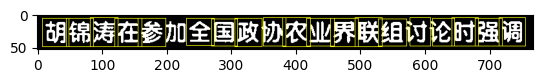

Similarity score: 576.5457801795881
Best match for char_10.png : 仑
Time taken in seconds: 1.6590723991394043
Similarity score: 488.5035384518424
Best match for char_14.png : 异
Time taken in seconds: 1.6212141513824463
Similarity score: 613.5353001223928
Best match for char_15.png : 业
Time taken in seconds: 1.6012077331542969
Similarity score: 627.3186199788069
Best match for char_17.png : 政
Time taken in seconds: 1.6066536903381348
Similarity score: 402.5649897034756
Best match for char_18.png : 余
Time taken in seconds: 1.5950515270233154
Similarity score: 420.5037381848525
Best match for char_20.png : 参
Time taken in seconds: 1.6251177787780762
Similarity score: 577.9153722962891
Best match for char_21.png : 茌
Time taken in seconds: 1.607987403869629
Similarity score: 580.3897035530895
Best match for char_22.png : 锦
Time taken in seconds: 1.6225230693817139
Similarity score: 497.3166521366812
Best match for char_23.png : 胡
Time taken in seconds: 1.6096656322479248
Similarity score: 45

In [7]:
# Extract characters from newspaper
image_path = 'resources/newspaper_cropped.jpg'
image = preprocess_image(image_path)
extract_characters(image)
# Recognize characters
initiate()
char_inputs = []
char_results = []
for images in os.scandir('chars/'):
    t0 = time.time()
    image = cv2.imread(images.path)
    image = preprocessing(image)
    loadFont(image.shape[0])
    filename = identify(image)
    char_inputs.append(image)
    char_results.append(filename)
    print('Best match for', images.name, ':', filename)
    t1 = time.time()
    print('Time taken in seconds:', t1 - t0)

Plot results:

<Figure size 2000x2000 with 0 Axes>

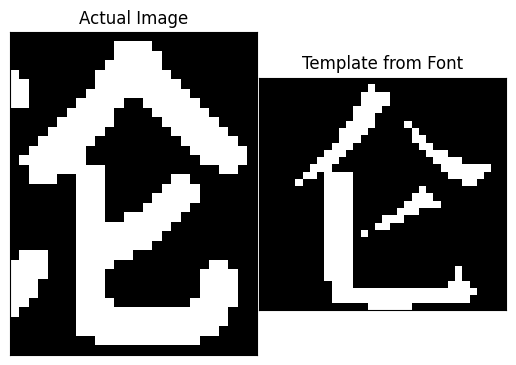

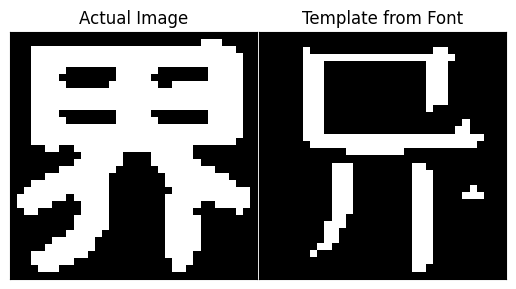

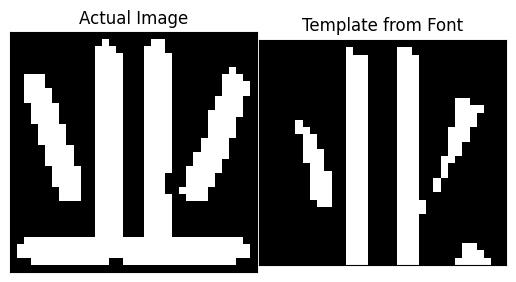

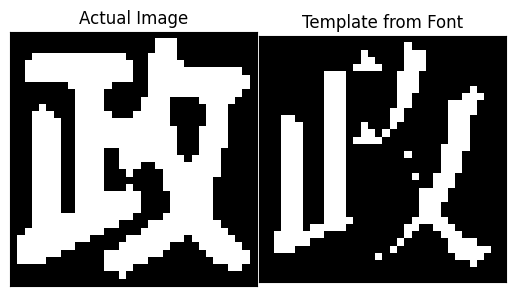

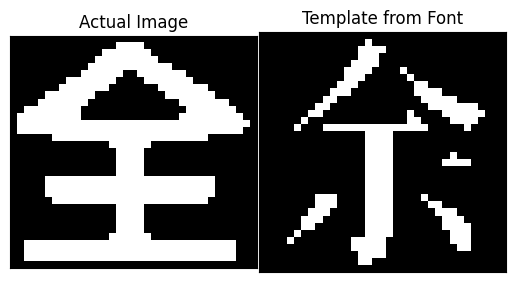

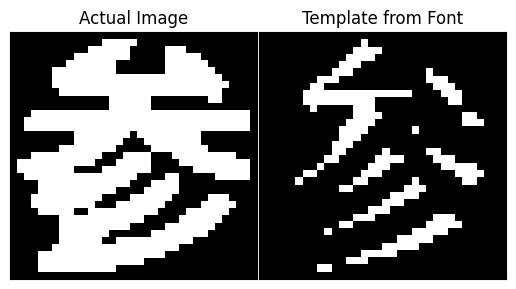

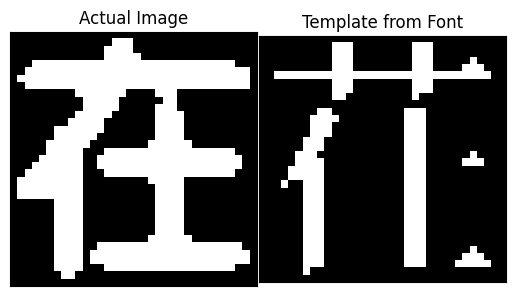

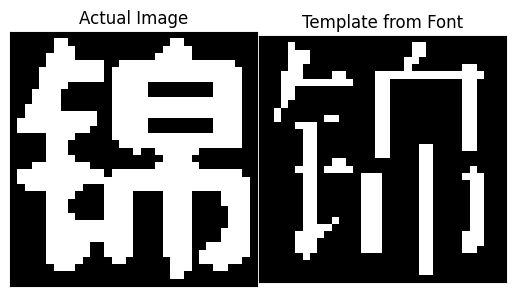

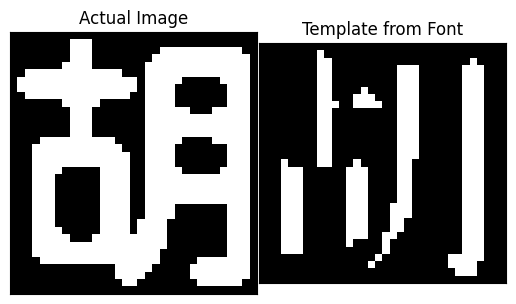

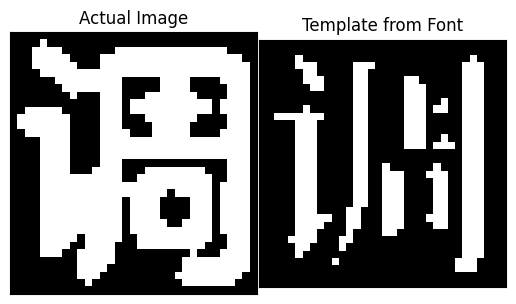

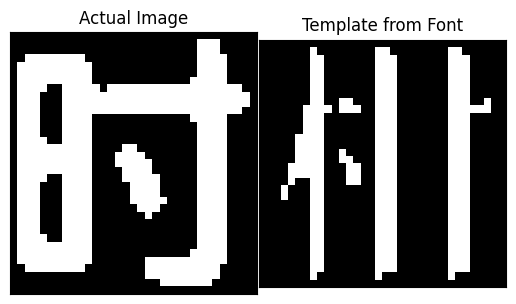

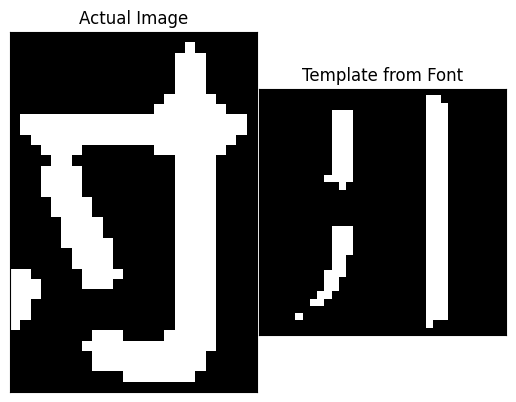

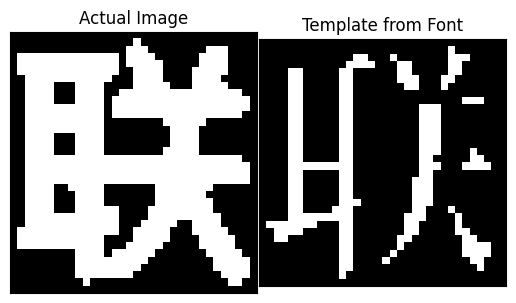

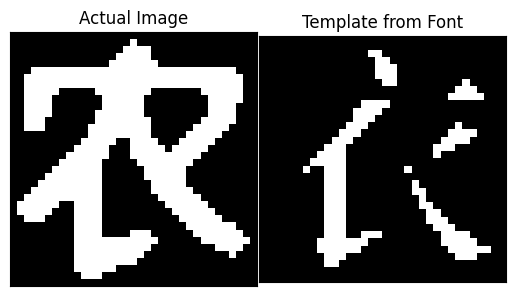

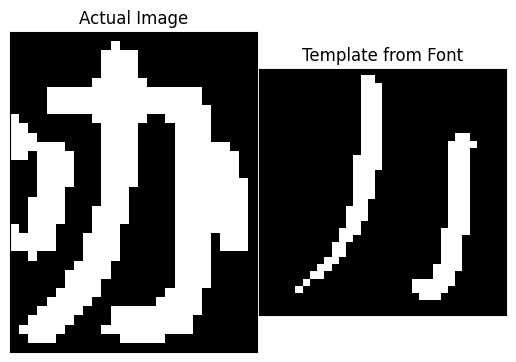

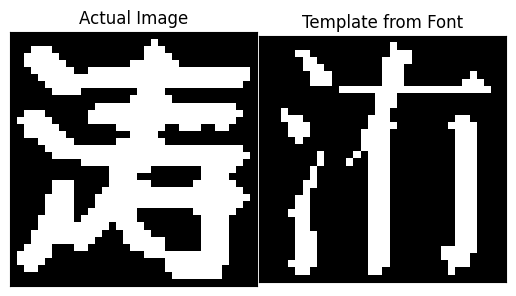

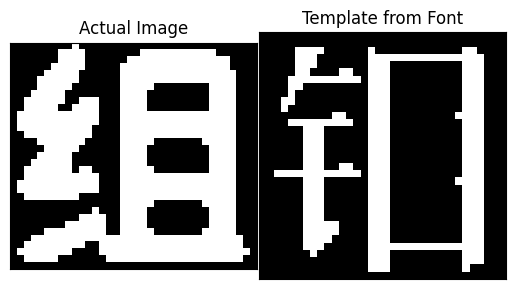

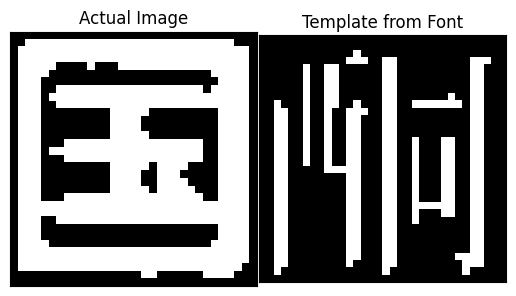

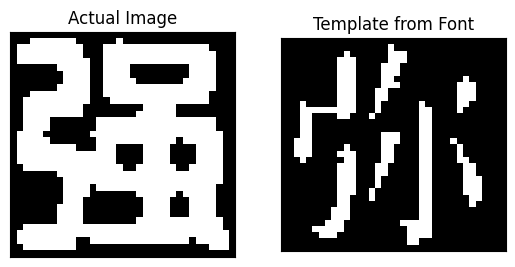

In [8]:
# plot results
num_images = len(char_inputs)
plt.figure(figsize=(20, 20))
for i in range(num_images):
  plt.subplots_adjust(wspace=0.01, hspace=0.05)
  plt.show()
  plt.subplot(121), plt.imshow(char_inputs[i], cmap='gray')
  plt.title('Actual Image'), plt.xticks([]), plt.yticks([])
  plt.subplot(122), plt.imshow(getCharacterImage(char_results[i]), cmap='gray')
  plt.title('Template from Font'), plt.xticks([]), plt.yticks([])